# **DSCI 100 - Group Project: Predicting Type 2 Diabetes**
Bhavya Mohan, Jason Jonathan, Sherin Xierenayi, Neha Menon

## **Introduction:** ##

Diabetes is a common chronic health condition characterized by abnormally high blood glucose levels caused by decreased capacity of producing insulin or cells becoming resistant to insulin. Approximately, 1.4 million people around the world are diagnosed as diabetic each year. Type 1 diabetes is a genetic condition that often shows up early in life, however type 2 diabetes is different as it is mainly lifestyle-related and develops over time. As a result, it's critical to identify type 2 diabetes at an early stage in order to stop the condition from progressing and possibly getting worse. We intend to create a predictive model that can accurately predict whether a person is diabetic, pre-diabetic, or non-diabetic based on their medical information.

We'll make use of a data set utilized in a previous study by Rajput et al., who retrieved it from the Iraqi society, as it was acquired from the laboratory of Medical City Hospital. The data consists of medical information and laboratory analysis of 1000 patients: 103 non-diabetic, 53 pre-diabetic, and 844 diabetic patients. The data contains different diabetes attributes such as Gender, Age, Urea level (Urea), Creatinine ratio (Cr), Blood Sugar Level (HbA1c), Cholesterol level (Chol), Triglycerides (TG), High-density lipoprotein (HDL), Low-density lipoprotein (LDL), Very-low-density lipoprotein (VLDL), and the patients' diagnosis (CLASS).

The question we are trying to answer is whether we can use previously diagnosed patients' medical attributes related to diabetes to predict whether a future patient with an unknown diagnosis falls into one of the three diabetes categories.

## **Methods & Results:**

In [97]:
# Loading Packages ----
install.packages("kknn")
install.packages("gridExtra")
library(ggplot2)
library(dplyr)
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)
library(gridExtra)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



We downloaded the data set as a .csv file from Mendeley to our remote repository on GitHub. We then loaded the data set from GitHub to our Jupyter notebook. The CLASS column contains the diagnoses of whether a patient is diabetic (Y), pre-diabetic (P), or non-diabetic (N). We used the as_factor function to mutate the CLASS column from a character variable to a factor variable.

In [98]:
# Load data ----

## CLASS refers to diabetes where n is no diabetes, y is diabetic, and p is poteintially diabetic

url <- "https://raw.githubusercontent.com/jasonj17/DSCI100Project/main/Dataset%20of%20Diabetes%20.csv"
diabetes <- read_csv(url)|>
                mutate(CLASS = as_factor(CLASS))

glimpse(diabetes) # calling the data set for viewing
### Data is already in Tidy Format but is unscaled

Rows: 1000 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Gender, CLASS
dbl (12): ID, No_Pation, AGE, Urea, Cr, HbA1c, Chol, TG, HDL, LDL, VLDL, BMI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,000
Columns: 14
$ ID        <dbl> 502, 735, 420, 680, 504, 634, 721, 421, 670, 759, 636, 788, …
$ No_Pation <dbl> 17975, 34221, 47975, 87656, 34223, 34224, 34225, 34227, 3422…
$ Gender    <chr> "F", "M", "F", "F", "M", "F", "F", "M", "M", "F", "F", "F", …
$ AGE       <dbl> 50, 26, 50, 50, 33, 45, 50, 48, 43, 32, 31, 33, 30, 45, 50, …
$ Urea      <dbl> 4.7, 4.5, 4.7, 4.7, 7.1, 2.3, 2.0, 4.7, 2.6, 3.6, 4.4, 3.3, …
$ Cr        <dbl> 46, 62, 46, 46, 46, 24, 50, 47, 67, 28, 55, 53, 42, 54, 39, …
$ HbA1c     <dbl> 4.9, 4.9, 4.9, 4.9, 4.9, 4.0, 4.0, 4.0, 4.0, 4.0, 4.2, 4.0, …
$ Chol      <dbl> 4.2, 3.7, 4.2, 4.2, 4.9, 2.9, 3.6, 2.9, 3.8, 3.8, 3.6, 4.0, …
$ TG        <dbl> 0.9, 1.4, 0.9, 0.9, 1.0, 1.0, 1.3, 0.8, 0.9, 2.0, 0.7, 1.1, …
$ HDL       <dbl> 2.4, 1.1, 2.4, 2.4, 0.8, 1.0, 0.9, 0.9, 2.4, 2.4, 1.7, 0.9, …
$ LDL       <dbl> 1.4, 2.1, 1.4, 1.4, 2.0, 1.5, 2.1, 1.6, 3.7, 3.8, 1.6, 2.7, …
$ VLDL      <dbl> 0.5, 0.6, 0.5, 0.5, 0.4, 0.4, 0.6, 0.4, 1.0, 1.0, 0.3, 1.0, …
$ BMI       <dbl

*Table 1: Unscaled diabetes data set (glimpsed)*

To get an idea of the distribution of classes in our data set, we used the group_by, summarize, and n functions to find the number and percentage of observations in each CLASS. We then calculate the percentage of observations in each CLASS by dividing by the total number of observations. We have 844 (84.4%) diabetic, 53 (5.3%) pre-diabetic, and 103 (10.3%) non-diabetic observations.

In [99]:
### Lets first look at the number of observations in each class
num_obs <- nrow(diabetes)

diabetes_summary <- diabetes |>
  group_by(CLASS)|>
  summarise(count=n(),
           percentage = n()/num_obs*100)
diabetes_summary

CLASS,count,percentage
<fct>,<int>,<dbl>
N,103,10.3
P,53,5.3
Y,844,84.4


*Table 2: The number and percentage of each CLASS within the whole data*

We decided to compute the mean values for each of the numerical predictors in our data set, excluding the Gender column since we cannot use a non-numerical variable as a predictor variable for classification. We used the mean function to calculate the mean values for each of the columns specified. 

In [100]:
### Mean Values for variables
# We only included nmumerical variables as non-numerical variables cannot be included as potential predictors
mean_predictors <- diabetes|>
summarize(across(AGE:BMI, mean))
mean_predictors

AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
53.528,5.124743,68.943,8.28116,4.86282,2.34961,1.20475,2.60979,1.8547,29.57802


*Table 3: The average value for each numerical predictors*

We confirmed that none of the observations in our data set have any missing data.

In [101]:
### Number of empty data points
number_empty <- diabetes |>
  is.na()|>
    sum()
number_empty

[1] 0

We used the recipe function to specify that the CLASS variable will be the target and all of the numerical variables are the predictors. We prepped the recipe with the step_scale and step_center functions to center and scale our data, specifying to apply these functions to all predictors. We then baked the unscaled diabetes data set with the recipe we created and stored the new, scaled data frame as scaled_diabetes.

In [102]:
### Scaling the data
uc_recipe <- recipe(CLASS ~ AGE + Urea + Cr + HbA1c + Chol + TG + HDL + LDL + VLDL + BMI, data = diabetes) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  prep()

scaled_diabetes <- bake(uc_recipe, diabetes)
glimpse(scaled_diabetes)

Rows: 1,000
Columns: 11
$ AGE   <dbl> -0.4009437, -3.1284516, -0.4009437, -0.4009437, -2.3329285, -0.9…
$ Urea  <dbl> -0.14470837, -0.21284763, -0.14470837, -0.14470837, 0.67296275, …
$ Cr    <dbl> -0.38248056, -0.11574609, -0.38248056, -0.38248056, -0.38248056,…
$ HbA1c <dbl> -1.334316, -1.334316, -1.334316, -1.334316, -1.334316, -1.689485…
$ Chol  <dbl> -0.50918099, -0.89328300, -0.50918099, -0.50918099, 0.02856183, …
$ TG    <dbl> -1.0345667, -0.6777236, -1.0345667, -1.0345667, -0.9631980, -0.9…
$ HDL   <dbl> 1.809850757, -0.158612731, 1.809850757, 1.809850757, -0.61287353…
$ LDL   <dbl> -1.08491445, -0.45716904, -1.08491445, -1.08491445, -0.54684696,…
$ VLDL  <dbl> -0.3697730, -0.3424774, -0.3697730, -0.3697730, -0.3970685, -0.3…
$ BMI   <dbl> -1.124060, -1.325575, -1.124060, -1.124060, -1.728607, -1.728607…
$ CLASS <fct> N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N…


*Table 4: Scaled diabetes data set (glimpsed)*

To choose the most appropriate predictor variables to use for our modelling, we created scatter plots to visualize the relationships between different predictor variables namely BMI vs. HbA1c, BMI vs. Age, HDL vs. Age, Cholesterol vs. Urea, and Age vs. Creatine. We constructed each scatter plot using the ggplot function paired with geom_point.

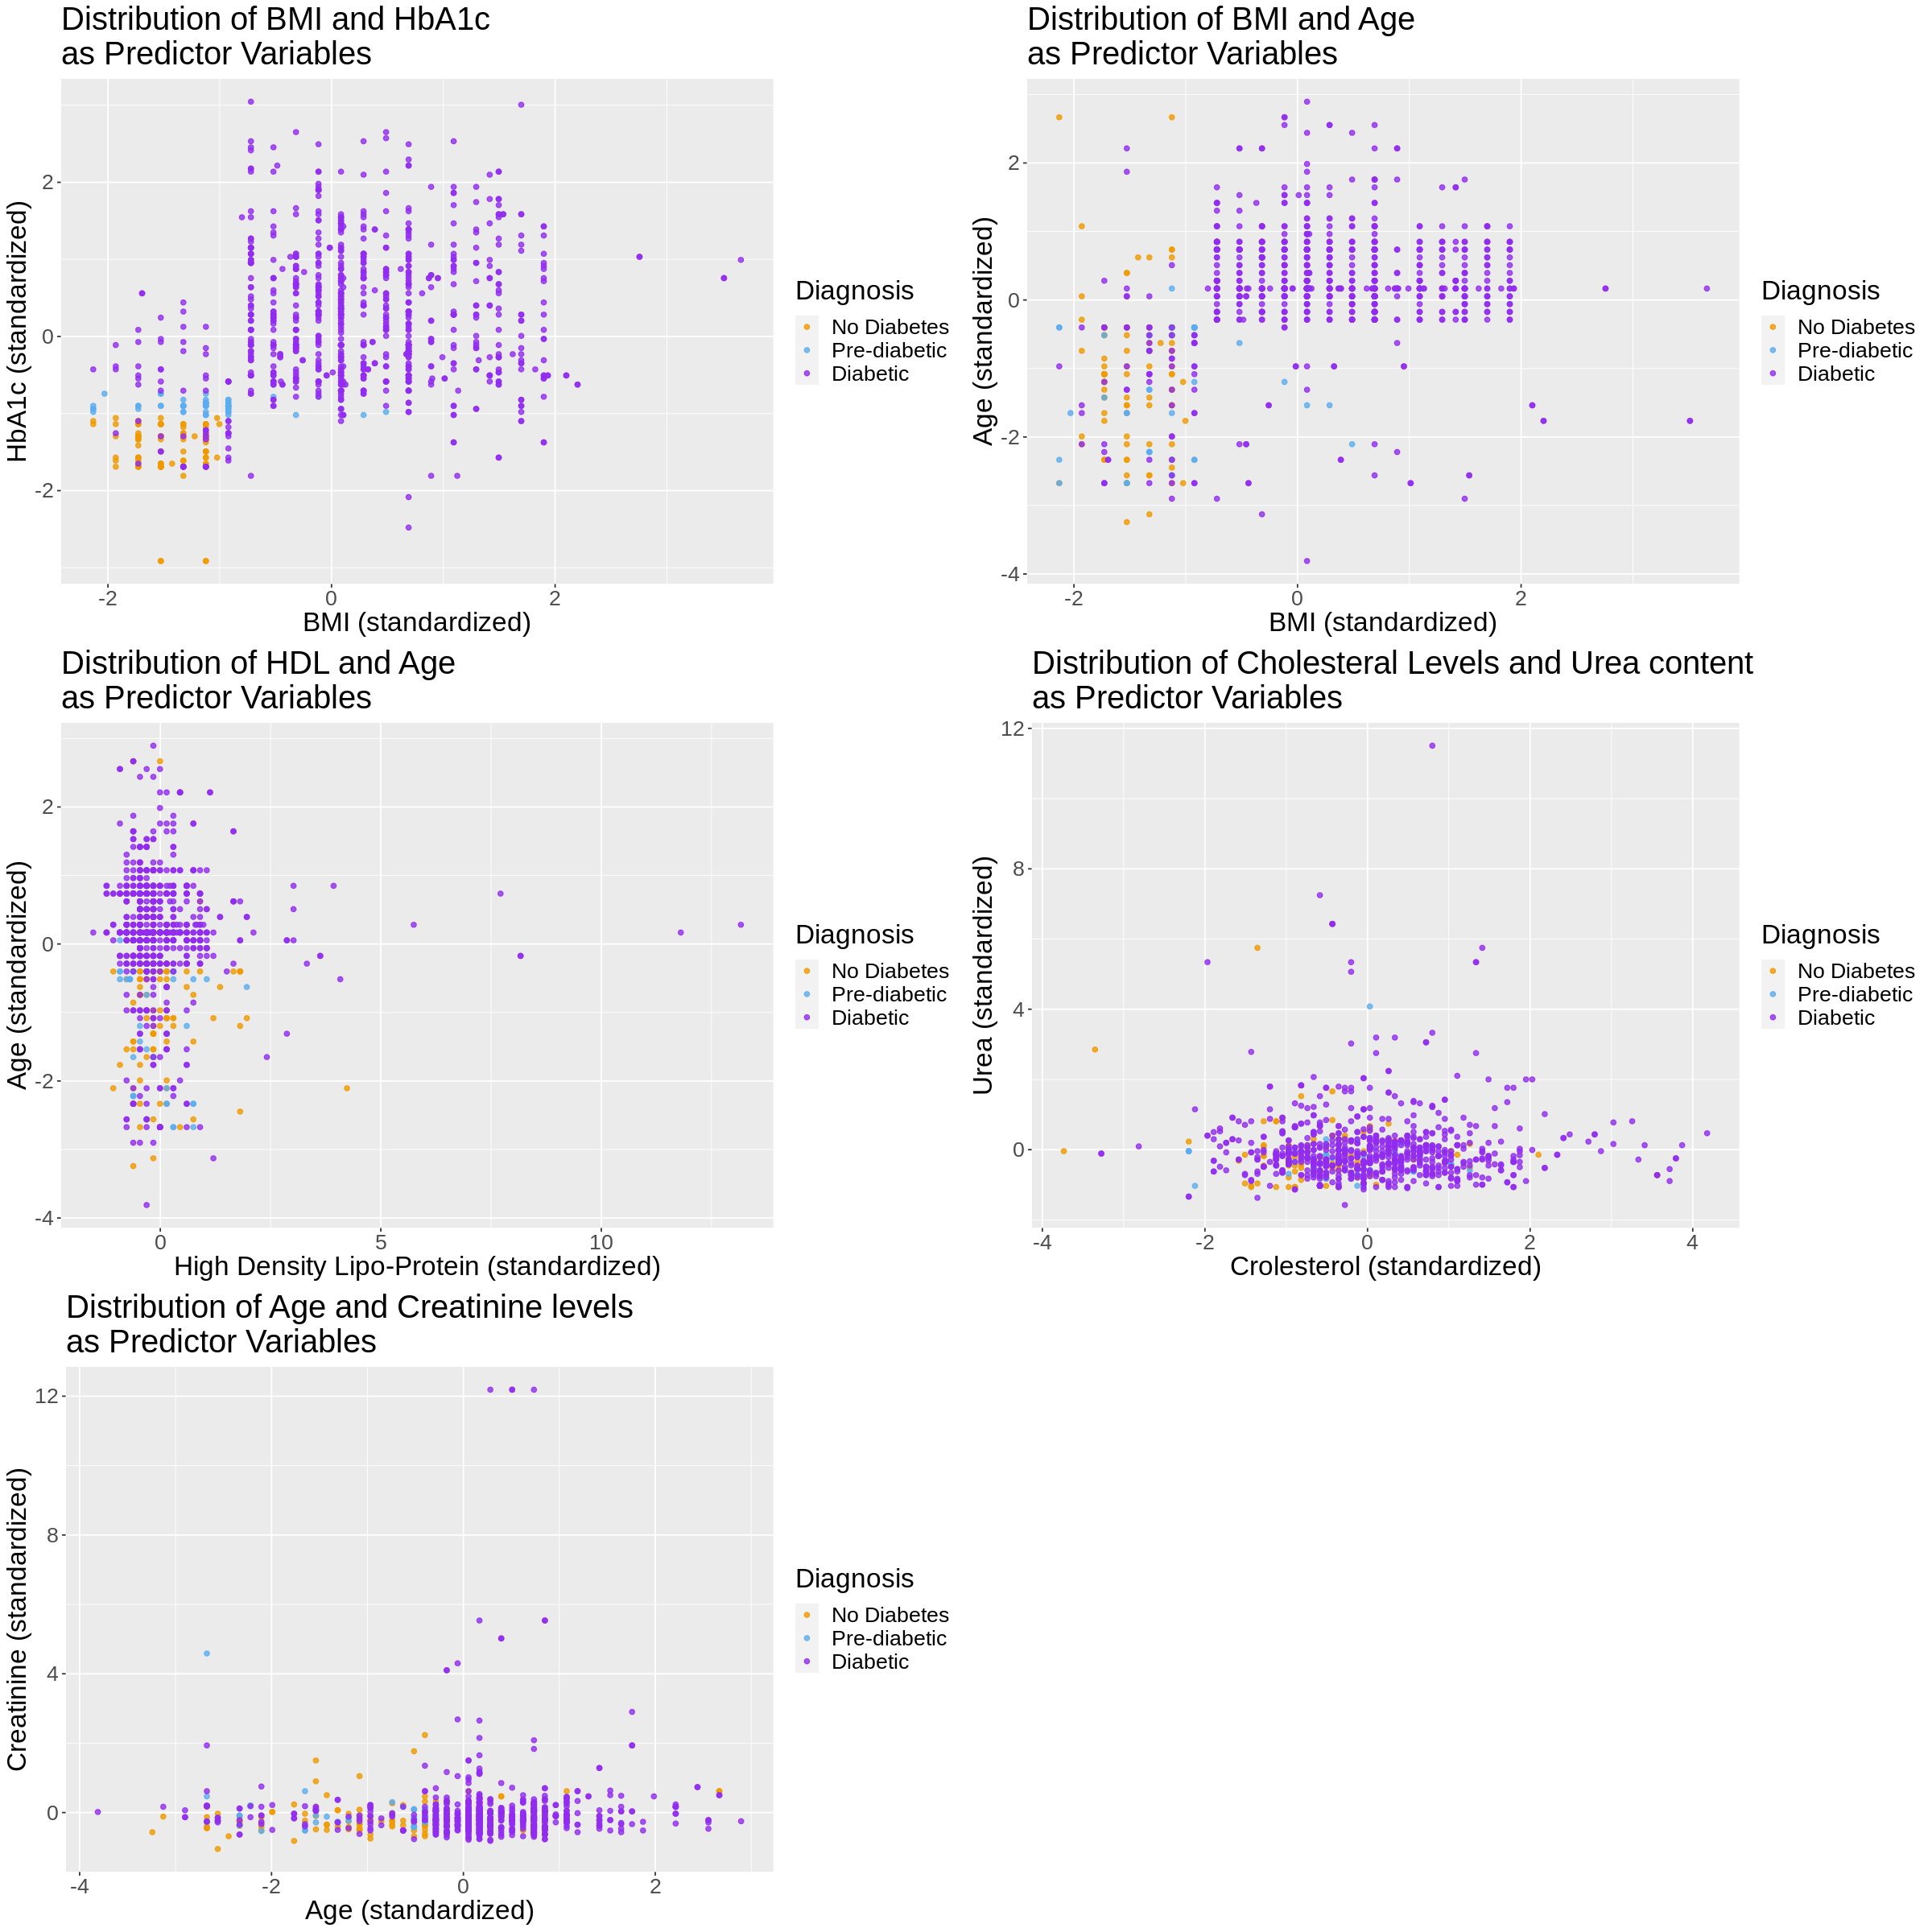

In [103]:
# Initial Graphs of different correlations----
options(repr.plot.width = 20, repr.plot.height = 20)

graph1 <- scaled_diabetes |>
    ggplot(aes(x = BMI, y = HbA1c, color = CLASS)) +
    geom_point(alpha = 0.8) +
    labs(x = "BMI (standardized)", y = "HbA1c (standardized)", color = "Diagnosis") +
    scale_color_manual(labels = c("No Diabetes", "Pre-diabetic", "Diabetic"), values = c("orange2", "steelblue2", 'purple2')) +
    theme(text = element_text(size = 20)) +
    ggtitle('Distribution of BMI and HbA1c \nas Predictor Variables')

graph2 <- scaled_diabetes |>
    ggplot(aes(x = BMI, y = AGE, color = CLASS)) +
    geom_point(alpha = 0.8) +
    labs(x = "BMI (standardized)", y = "Age (standardized)", color = "Diagnosis") +
    scale_color_manual(labels = c("No Diabetes", "Pre-diabetic", "Diabetic"), values = c("orange2", "steelblue2", 'purple2')) +
    theme(text = element_text(size = 20)) +
    ggtitle('Distribution of BMI and Age \nas Predictor Variables')

graph3 <- scaled_diabetes |>
    ggplot(aes(x = HDL, y = AGE, color = CLASS)) +
    geom_point(alpha = 0.8) +
    labs(x = "High Density Lipo-Protein (standardized)", y = "Age (standardized)", color = "Diagnosis") +
    scale_color_manual(labels = c("No Diabetes", "Pre-diabetic", "Diabetic"), values = c("orange2", "steelblue2", 'purple2')) +
    theme(text = element_text(size = 20)) +
    ggtitle('Distribution of HDL and Age \nas Predictor Variables')

graph4 <- scaled_diabetes |>
    ggplot(aes(x = Chol, y = Urea, color = CLASS)) +
    geom_point(alpha = 0.8) +
    labs(x = "Crolesterol (standardized)", y = "Urea (standardized)", color = "Diagnosis") +
    scale_color_manual(labels = c("No Diabetes", "Pre-diabetic", "Diabetic"), values = c("orange2", "steelblue2", 'purple2')) +
    theme(text = element_text(size = 20)) +
    ggtitle('Distribution of Cholesteral Levels and Urea content \nas Predictor Variables')

graph5 <- scaled_diabetes |>
    ggplot(aes(x = AGE, y = Cr, color = CLASS)) +
    geom_point(alpha = 0.8) +
    labs(x = "Age (standardized)", y = "Creatinine (standardized)", color = "Diagnosis") +
    scale_color_manual(labels = c("No Diabetes", "Pre-diabetic", "Diabetic"), values = c("orange2", "steelblue2", 'purple2')) +
    theme(text = element_text(size = 20)) +
    ggtitle('Distribution of Age and Creatinine levels \nas Predictor Variables')

grid.arrange(graph1, graph2, graph3, graph4, graph5, ncol=2, nrow =3)

*Figures 1-5: Scatter plots of relationships between different predictor variables of BMI vs. HbA1c, BMI vs. Age, HDL vs. Age, Cholesterol vs. Urea, and Age vs. Creatinine respectively.*

Based on the plots we generated in our exploratory data analysis, we decided to use the BMI and HbA1c variables as the predictor variables for our classifier model since the distribution plot between these two variables shows observations from each class being located in separate areas from one another which is promising for a K-nearest neighbors classification model. In particular, non-diabetic observations tend to have lower BMI and HbA1c values while diabetic observations tend to have larger values. Pre-diabetic observations tend to have a HbA1c value in between diabetic and non-diabetic observations, but this is not necessarily true for their BMI value. The plot shows us that pre-diabetic observations have relatively the same range of BMI values as non-diabetic observations, but they tend to have higher HbA1c values. There are also several diabetic observations that are in the same range of BMI values as non-diabetic observations, but the diabetic observations have considerably higher Hb1Ac values. As a result, it seems that the value of HbA1c weighs more in classifying a certain observation than the value of BMI.

A hemoglobin A1C (HbA1C)1 test is a blood test that shows what your average blood sugar (glucose) level was over the past two to three months. Body Mass Index (BMI) is a person’s weight in kilograms divided by the square of height in meters. Part of our decision to use Hb1Ac and BMI as predictor variables are also because they are common measurements that are used in the diagnosis of diabetes. Part of our decision to use Hb1Ac and BMI as predictor variables are also because they are common measurements that are used in the diagnosis of diabetes.

In order to evaluate our classifier's accuracy on unseen data, we need to split our data set into training and testing sets using the initial_split function. To ensure that the split is done randomly but is also reproducible, we set a random seed value with the set.seed function. We specified prop to be 0.75 so that 75% of our original data ends up in the training set and 25% of our original data ends up in the testing set. We set the strata argument to the CLASS variable, to ensure that the training and testing subsets contain the right proportions of each category of observation. 

In [104]:
#### Setting the seed
set.seed(1035)

# Creating training and testing splits
diabetes_split <- initial_split(scaled_diabetes, prop = 0.75, strata = CLASS)  
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

To make sure that our class proportions were roughly preserved when the data was split, we used the group_by, summarize, and n functions to find the number and percentage of observations in each CLASS like we did earlier. We can see that the class proportions were successfully preserved.

In [105]:
# Making sure that our class proportions were roughly preserved when we split the data
diabetes_proportions <- diabetes_train |>
                            group_by(CLASS) |>
                            summarize(n = n()) |>
                            mutate(percent = 100*n/nrow(diabetes_train))
diabetes_proportions

CLASS,n,percent
<fct>,<int>,<dbl>
N,75,10.013351
P,40,5.340454
Y,634,84.646195


*Table 5: The number and percentage of each CLASS within the training (diabetes_train) data set after splitting*

We created a new recipe with only our chosen variables, BMI and HbA1c, as the predictor variables.

In [106]:
# Creating recipe with our chosen predictor variables
diabetes_recipe <- recipe(CLASS ~ BMI + HbA1c, data = diabetes_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

To choose the best value of K for our classifier model, we use a 10-fold cross-validation to calculate an accuracy for each value of K in a reasonable range (1-20). To do this, we created a model specification and specified that the neighbors argument is going to be tuned using tune(). We then created the k_vals data frame with a neighbors variable containing values from 1 to 20 (stepping by 1) using the seq function. To perform the 10-fold cross-validation, we use the vfold_cv function with v = 10 to specify that we want to split the diabetes_train datas et into 10 folds. 

Next, we created our data analysis workflow with the tune_grid function to fit the model for each value of K. We specified diabetes_recipe, which we created earlier, as our recipe and knn_tune as our model specification for the workflow. We pass the 10-fold cross-validation model we created before to the resamples argument and the k_vals data frame to the grid argument of the tune_grid function. We then use the collect_metrics function to aggregate the mean and standard error of the classifier's validation accuracy across the folds.

In [107]:
# Choosing an appropriate value for K
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

diabetes_vfold <- vfold_cv(diabetes_train, v = 10, strata = CLASS)

knn_results <- workflow() |>
                add_recipe(diabetes_recipe) |>
                add_model(knn_tune) |>
                tune_grid(resamples = diabetes_vfold, grid = k_vals) |>
                collect_metrics()

In the knn_results data frame, we filtered the .metric to include only the accuracy metric as it is the only metric we are interested in to choose the value of K that gives us the best accuracy. It was found that K = 12 gives us the highest accuracy (around 95.5%) for our classifier model, however, the relative accuracy between all of the K values from 1 to 20 was similar with all of them being quite high.

In [108]:
# Finding the accuracy for each value of k from 1 to 20
accuracies <- knn_results |> 
                filter(.metric == "accuracy") |>
                select(-.config)
accuracies

neighbors,.metric,.estimator,mean,n,std_err
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
1,accuracy,multiclass,0.9545756,10,0.005373873
2,accuracy,multiclass,0.9545936,10,0.004547020
3,accuracy,multiclass,0.9519094,10,0.006033412
4,accuracy,multiclass,0.9532428,10,0.005716275
5,accuracy,multiclass,0.9452608,10,0.009204397
6,accuracy,multiclass,0.9452428,10,0.008076655
7,accuracy,multiclass,0.9492428,10,0.008166735
8,accuracy,multiclass,0.9492428,10,0.008166735
9,accuracy,multiclass,0.9519275,10,0.007495760


*Table 6: Mean and standard error of the classifier model's validation accuracy with different values of K from 1 to 20 generated through a 10-fold cross-validation*

We plotted the accuracy of the classifier model against the K value to find the K value that will generate the highest accuracy. As the plot shows, all of the K values from 1 to 20 gave relatively similar accuracies with all of them being quite high (above 94%).

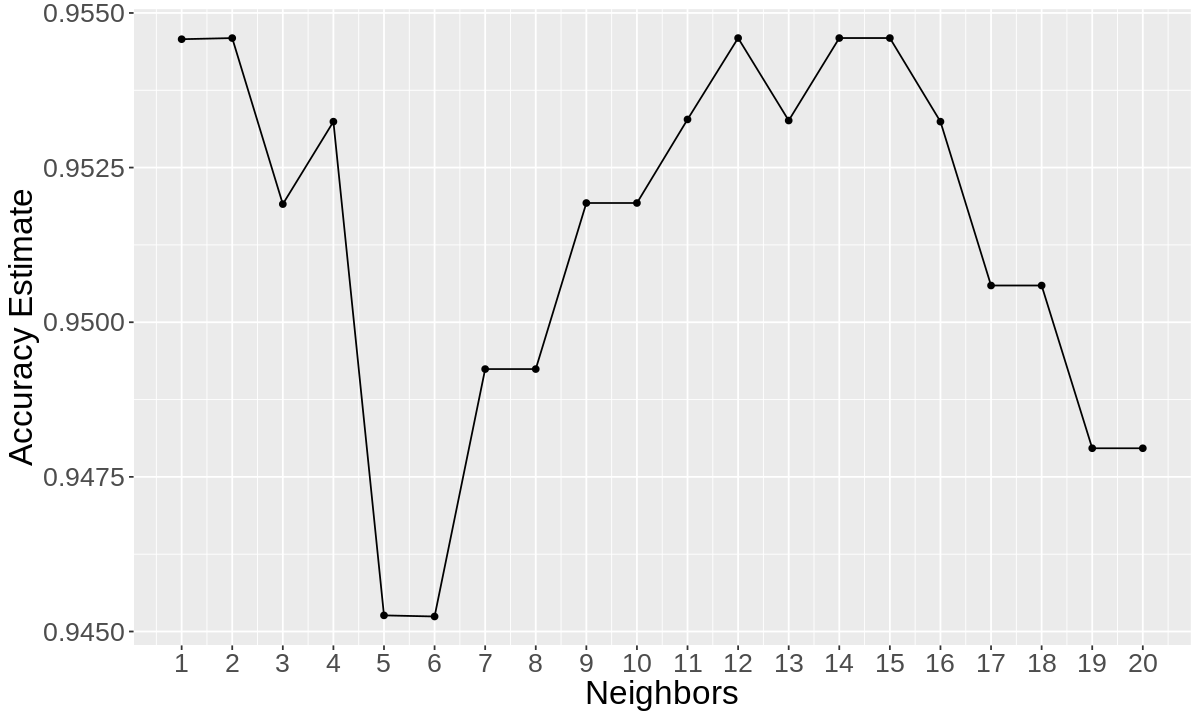

In [109]:
# Generate plot of accuracy vs. k
options(repr.plot.width = 10, repr.plot.height = 6)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    scale_x_continuous(breaks = seq(0, 20, by = 1)) +
                    theme(text = element_text(size = 20))
accuracy_vs_k

*Figure 6: Plot of estimated accuracy versus the number of neighbors.*

Because the difference in accuracy between each value of K is very small (Figure 6), any selection from K = 1 to K = 20 is reasonably justified, but we decided to choose K = 12 to use for our classifier model as the accuracy table above (Table 6) shows us that K = 12 was estimated to give us the best accuracy.

We created a new model specification using the value of K =12 as it was found to generate the highest accuracy for our classifier model.

In [110]:
# Creating the best specification for our knn classifier model using k = 12
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) |>
                    set_engine("kknn") |>
                    set_mode("classification")

We created a new data analysis workflow with the same recipe (diabetes_recipe) that we created earlier, but this time using the new model specification that we created with K = 12. We then fitted the workflow to the diabetes_train data set to train our classifier model.

In [111]:
# Creating the workflow for our knn classifier model
diabetes_best_fit <- workflow() |>
                add_recipe(diabetes_recipe) |>
                add_model(knn_best_spec) |>
                fit(data = diabetes_train)

We then passed the new data analysis workflow to the predict function to allow our classifier to predict the CLASS of the observations in the diabetes_test data set. We then binded the predictions that our classifier made to the diabetes_test data set itself and stored it as a new variable called diabetes_test_predictions.

In [112]:
# Fitting our classifier model to the test data
diabetes_test_predictions <- predict(diabetes_best_fit, diabetes_test) |> 
                                bind_cols(diabetes_test)
glimpse(diabetes_test_predictions)

Rows: 251
Columns: 12
$ .pred_class <fct> N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N…
$ AGE         <dbl> -3.1284516, -0.9691745, -0.6282360, -1.1964668, -2.5602208…
$ Urea        <dbl> -0.21284763, -0.96237948, -0.14470837, -0.86017059, -0.246…
$ Cr          <dbl> -0.1157460905, -0.7492404644, -0.3658096591, -0.0323915676…
$ HbA1c       <dbl> -1.334316, -1.689485, -1.689485, -1.689485, -1.610558, -1.…
$ Chol        <dbl> -0.89328300, -1.50784622, -1.50784622, -0.81646260, -0.970…
$ TG          <dbl> -0.6777236, -0.9631980, -1.1059353, -1.0345667, -1.1773039…
$ HDL         <dbl> -0.158612731, -0.310032999, -0.461453268, 1.809850757, 0.7…
$ LDL         <dbl> -0.457169044, -0.995236535, -0.905558620, 0.977677600, -0.…
$ VLDL        <dbl> -0.3424774, -0.3970685, -0.3970685, -0.2332952, -0.4243641…
$ BMI         <dbl> -1.325575, -1.728607, -1.124060, -1.728607, -1.325575, -1.…
$ CLASS       <fct> N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N…


*Table 7: Predictions (.pred_class) made on the testing data set by our classifier model*

To assess the accuracy of our classifier model, we use the metrics function to get the statistics about the quality of our model, specifying the truth argument as CLASS and the estimate argument as .pred_class. An accuracy of 95.2% is observed which means that our model is well designed and relatively accurate. This accuracy is only 0.3% lower than the accuracy estimate we obtained for K = 12 from our 10-fold cross-validation which is 95.5%.

In [113]:
# Showing the accuracy of the predictions that our classifier model made on the test data
diabetes_accuracy <- diabetes_test_predictions |>
                        metrics(truth = CLASS, estimate = .pred_class) |> 
                        filter(.metric == "accuracy")
diabetes_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9521912


*Table 8: The accuracy of the predictions our classifier model made on the testing (diabetes_test) data set with K = 12*

We also generated a confusion matrix, a table of predicted labels and correct labels, of the predictions that our classifier made on the testing set using the conf_mat function. The confusion matrix shows 200 observations were correctly predicted as diabetic, 12 were correctly predicted as pre-diabetic, and 27 were correctly predicted as non-diabetic. Therefore the classifier labeled 239 observations correctly and 12 incorrectly. 

In [114]:
# Showing the confusion matrix of the predictions that our classifier made on the test data
diabetes_confusion_matrix <- diabetes_test_predictions |> 
                                conf_mat(truth = CLASS, estimate = .pred_class)
diabetes_confusion_matrix

          Truth
Prediction   N   P   Y
         N  27   1   9
         P   0  12   1
         Y   1   0 200

*Table 9: Confusion matrix of the predictions that our classifier made on the testing (diabetes_test) data set, showing the predicted and true labels of each observation*

We visualized the predictions that our trained K-nearest neighbors classifier model will make on a large range of new observations using the scaled_diabetes data set. The background color of the plot corresponds to the class that our classifier predicted.

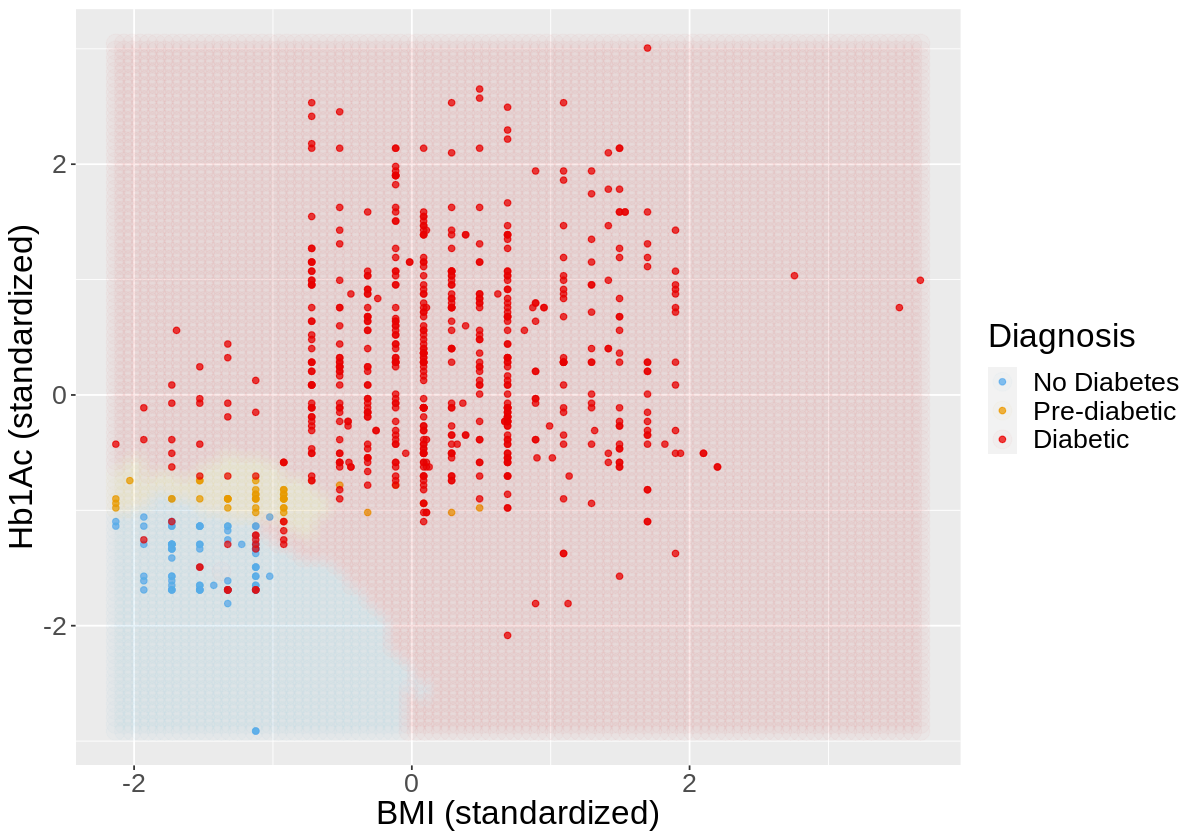

In [115]:
# Scatter plot of Hb1Ac concentration versus BMI concentration where background color indicates the decision of the classifier
options(repr.plot.width = 10, repr.plot.height = 7)
bmi_grid <- seq(min(scaled_diabetes$BMI), 
                max(scaled_diabetes$BMI), 
                length.out = 100)
HbA1c_grid <- seq(min(scaled_diabetes$HbA1c),
                  max(scaled_diabetes$HbA1c),
                  length.out = 100)
asgrid <- as_tibble(expand.grid(BMI = bmi_grid, 
                                HbA1c = HbA1c_grid))


# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(diabetes_best_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
                        rename(Class = .pred_class)

wkflw_plot <- ggplot() +
                geom_point(data = diabetes_train, mapping = aes(x = BMI, y = HbA1c, color = CLASS), alpha = 0.75) +
                geom_point(data = prediction_table, mapping = aes(x = BMI, y = HbA1c, color = Class), alpha = 0.02, size = 5) +
                labs(color = "Diagnosis", x = "BMI (standardized)", y = "Hb1Ac (standardized)") +
                scale_color_manual(labels = c("No Diabetes", "Pre-diabetic", "Diabetic"), values = c("steelblue2", "orange2", "red2")) +
                theme(text = element_text(size = 20))
wkflw_plot

*Figure 7: Scatter plot of BMI versus Hb1Ac where background color indicates the decision of the classifier*

## **Discussion**

Through this analysis, we demonstrated that we were able to construct a classifier model that can accurately predict whether a person is diabetic, pre-diabetic, or non-diabetic based on their HbA1c and BMI measurements. Our classifier model was 95.2% accurate when predicting on the test data set. This is a good value for accuracy because it is higher than the majority classifier's accuracy which is 84.6% since the majority classifier's accuracy is close to the majority class proportion in the training data. For our application, it is important that the classifier does not misdiagnose a diabetic patient as non-diabetic. The confusion matrix above shows that the classifier only misdiagnosed 9 out of 210 diabetic observations as non-diabetic (only 4.3%). In addition, the confusion matrix also showed that only 12 predictions out of 251 total predictions (4.8%) were predicted incorrectly. Therefore, our critical analysis suggests that we have successfully created a classifier model with the appropriate performance for its intended application.

Based on previous literature, we expected HbA1c and BMI to be the best variables to use when predicting diabetes and would produce a highly accurate classifier model. The result we obtained from our analysis matches what we expect to find since our results show that higher values of HbA1c and BMI are positively correlated with type 2 diabetes patients and can be used as predictor variables to generate a highly accurate classifier model that can predict diabetes.

These findings impact the factors necessary to diagnose someone with type 2 diabetes, and could possibly simplify the process. Since BMI and Hb1Ac served as accurate predictor variables to predict diabetes, it is possible that they can be used to supplement current diagnostic tests. Currently, blood sugar is the main measurement used to diagnose type 2 diabetes but considering there are other variables strongly related, it provides more opportunity to enhance testing. In addition, blood tests are somewhat invasive and considering that BMI is a strong predictor of diabetes, easy to calculate and less invasive, it could help to identify individuals at risk at a larger scale level. Doctors can also use the classifier to get a quick prediction on the diagnosis of patients before moving on to other medical tests which may take some time to get results.

This analysis poses the question if type 1 diabetes follows the same trend as the one observed within this model. Type 1 diabetes is a genetic condition while type 2 diabetes is mainly lifestyle-related, therefore it might not present the same accuracy with the predictor variables we used, though it would be interesting to compare the accuracies of this model with type 1 diabetes data. Furthermore, it is also interesting to see if being overweight (having a high BMI) plays a factor in directly causing diabetes.

## **References**

1. Gray, B. J., Bracken, R. M., Turner, D., Morgan, K., Thomas, M., Williams, S. P., Williams, M., Rice, S., Stephens, J. W., & Prosiect Sir Gâr Group. (2016). Examining the relationship between HbA1c and diabetes risk models in a european population indicates a lower threshold to identify ‘high risk’ is required. Diabetes & Vascular Disease Research, 13(3), 228-235. https://doi.org/10.1177/1479164116629351 
2. Rajput, Minakshi R., and Sushant S. Khedgikar. 2022. “Diabetes Prediction and Analysis Using Medical Attributes: A Machine Learning Approach.” Journal of Xi’an University of Architecture & Technology 14(1):98–103. Doi: 10.37896/JXAT14.01/314405.
3. Wysham, C., Bonadonna, R. C., Aroda, V. R., Puig Domingo, M., Kapitza, C., Stager, W., Yu, C., Niemoeller, E., Souhami, E., Bergenstal, R. M., & LixiLan-L trial investigators. (2017). Consistent findings in glycaemic control, body weight and hypoglycaemia with iGlarLixi (insulin glargine/lixisenatide titratable fixed‐ratio combination) vs insulin glargine across baseline HbA1c, BMI and diabetes duration categories in the LixiLan‐L trial. Diabetes, Obesity & Metabolism, 19(10), 1408-1415. https://doi.org/10.1111/dom.12961 